<a href="https://colab.research.google.com/github/Oebele/Deep-lerning-for-beginners/blob/master/Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders

## The heart disease dataset revisited

--2020-10-15 12:31:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [application/x-httpd-php]
Saving to: ‘processed.cleveland.data’

processed.cleveland 100%[===================>]  18.03K  --.-KB/s    in 0.1s    

2020-10-15 12:31:02 (140 KB/s) - ‘processed.cleveland.data’ saved [18461/18461]



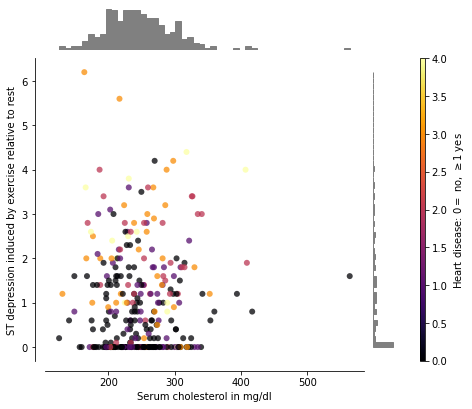

In [1]:
# Inspired by this post: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
# Modified by: Pablo Rivas
# Comes from Chapter 3

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler, minmax_scale

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

df = pd.read_csv('processed.cleveland.data', header=None)
df = df.apply(pd.to_numeric, errors='coerce').dropna()

X = df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].values
y_full = df[13].values

y = minmax_scale(y_full)


cmap = getattr(cm, 'inferno', cm.hot_r)

def create_axes(title, figsize=(6, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.74
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.12
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)


    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            ax_colorbar)


def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 4], X[:, 9], alpha=0.75, marker='o', lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 9], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 4], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')
    
def make_plot(X):
    title = ""
    ax_zoom_out, ax_colorbar = create_axes(title)
    plot_distribution(ax_zoom_out, X, y, hist_nbins=50,
                      x0_label="Serum cholesterol in mg/dl",
                      x1_label="ST depression induced by exercise relative to rest")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Heart disease: $0=$ no, $\geq 1$ yes')
    # plt.savefig('ch.9.heart.png', bbox_inches='tight', dpi=350)
    
make_plot(X)

## The re-parametrization trick and sampling¶


In [2]:
from tensorflow.keras import backend as K

def sampling(z_params):
  z_mean, z_log_var = z_params
  batch = K.shape(z_mean)[0]
  dims = K.int_shape(z_mean)[1]
  epsilon = K.random_normal(shape=(batch, dims)) 
  return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [3]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaler.fit(X)
x_train = scaler.transform(X)
original_dim = x_train.shape[1]

In [4]:
input_shape = (original_dim, )
intermediate_dim = 13
batch_size = 18 # comes from ceil(sqrt(x_train.shape[0])) 
latent_dim = 2 # useful for visualization
epochs = 500

In [5]:
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

inputs = Input(shape=input_shape) 
bn = BatchNormalization()(inputs)

dp = Dropout(0.2)(bn)
x = Dense(intermediate_dim, activation='sigmoid')(dp)
x = Dropout(0.2)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z_params = [z_mean, z_log_var]
z = Lambda(sampling, output_shape=(latent_dim,))(z_params) 
encoder = Model(inputs, [z_mean, z_log_var, z])


## Modeling the decoder

In [6]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs) 
r_outputs = Dense(original_dim)(x) # reconstruction outputs 
decoder = Model(latent_inputs, r_outputs)

In [7]:
outputs = decoder(encoder(inputs)[2]) # it is index 2 since we want z 
vae = Model(inputs, outputs)

## Minimizing the loss


In [8]:
from tensorflow.keras.losses import mse 
r_loss = mse(inputs, outputs)

In [9]:
from tensorflow.keras.losses import binary_crossentropy 
r_loss = binary_crossentropy(inputs, outputs)

In [10]:
r_loss = original_dim * r_loss


In [11]:
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var) 
kl_loss = 0.5 * K.sum(kl_loss, axis=-1)

In [12]:
vae_loss = K.mean(r_loss + kl_loss) 
vae.add_loss(vae_loss)

## Training a VAE¶


In [13]:
vae.compile(optimizer='adam')


In [14]:
hist = vae.fit(x_train, epochs=epochs, batch_size=batch_size,
               validation_data=(x_train, None))

Epoch 1/500
17/17 [==============================] - 0s 25ms/step - loss: 7.3421 - val_loss: 3.3733
Epoch 2/500
17/17 [==============================] - 0s 3ms/step - loss: 2.7489 - val_loss: 3.7258
Epoch 3/500
17/17 [==============================] - 0s 3ms/step - loss: 3.4950 - val_loss: 2.0728
Epoch 4/500
17/17 [==============================] - 0s 3ms/step - loss: 3.2427 - val_loss: 2.0636
Epoch 5/500
17/17 [==============================] - 0s 3ms/step - loss: 2.2007 - val_loss: 2.2345
Epoch 6/500
17/17 [==============================] - 0s 3ms/step - loss: 4.0399 - val_loss: 0.3008
Epoch 7/500
17/17 [==============================] - 0s 3ms/step - loss: 0.4810 - val_loss: -1.7810
Epoch 8/500
17/17 [==============================] - 0s 3ms/step - loss: 2.6751 - val_loss: 0.3627
Epoch 9/500
17/17 [==============================] - 0s 3ms/step - loss: 2.1484 - val_loss: 0.0462
Epoch 10/500
17/17 [==============================] - 0s 3ms/step - loss: -1.0553 - val_loss: -0.8770
Epoch

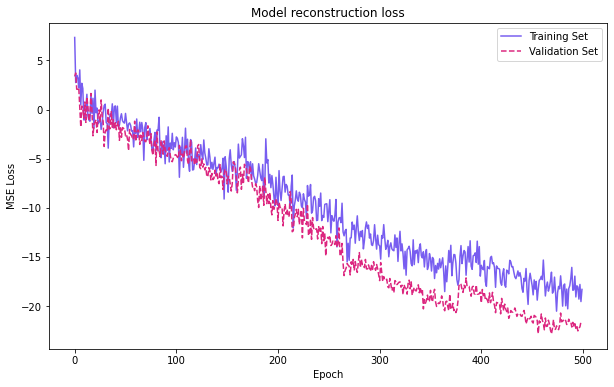

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], '--', color='#dc267f')
plt.title('Model reconstruction loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
# plt.savefig('ch.9.vae.heart.loss.png', dpi=350, bbox_inches='tight')
plt.show()

[ 0.93618065  0.69109474 -2.24062879  0.75038004 -0.27644339  2.43042728
  1.01019851  0.01749443 -0.69641941  1.06896529  2.26414539 -0.72197605
  0.65587737]
[-0.23160172  0.38106477 -0.3962947   0.40628847 -1.3509905  -0.5324474
 -0.49240753 -0.26517004 -0.4176146   1.02175     0.6643969  -0.8038882
  0.57409227]
[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   6. ]
[ 52.4   0.9   2.8 138.9 177.2  -0.    0.5 143.5   0.1   2.2   2.   -0.1
   5.8]


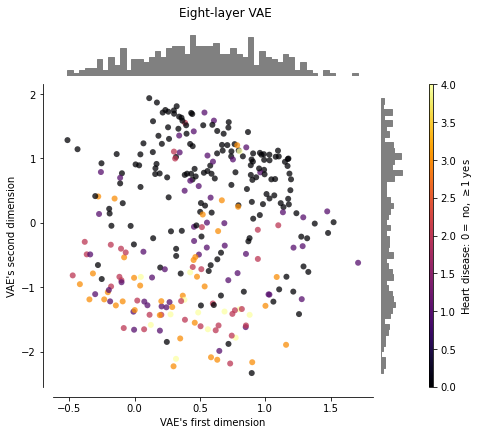

In [16]:
import matplotlib.pyplot as plt
import numpy as np

encdd = encoder.predict(x_train)
x_hat = decoder.predict(encdd[0])

print(x_train[0])
print(x_hat[0])

np.set_printoptions(suppress=True)
print(np.around(scaler.inverse_transform(x_train[0]), decimals=1))
print(np.around(scaler.inverse_transform(x_hat[0]), decimals=1))

def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.75, marker='o', lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')

def make_plot(X):
    title = "Eight-layer VAE"
    ax_zoom_out, ax_colorbar = create_axes(title)
    plot_distribution(ax_zoom_out, X, y, hist_nbins=50,
                      x0_label="VAE's first dimension",
                      x1_label="VAE's second dimension")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Heart disease: $0=$ no, $\geq 1$ yes')
    plt.savefig('ch.9.vae.heart.8l.png', bbox_inches='tight', dpi=350)
    
make_plot(encdd[0])


## Generating data from the VAE

In [17]:
encdd = encoder.predict(x_train) 
x_hat = decoder.predict(encdd[0])


In [18]:
import numpy as np 
print(np.around(scaler.inverse_transform(x_train[0]), decimals=1)) 
print(np.around(scaler.inverse_transform(x_hat[0]), decimals=1))

[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   6. ]
[ 52.4   0.9   2.8 138.9 177.2  -0.    0.5 143.5   0.1   2.2   2.   -0.1
   5.8]


In [19]:
def generate_samples(N = 10, latent_dim = 2):
  noise = np.random.uniform(-2.0, 2.0, (N,latent_dim))
  gen = decoder.predict(noise)
  return gen

gen = generate_samples(10, latent_dim)
print(np.around(scaler.inverse_transform(gen), decimals=1))

[[ 54.    0.8   2.8 135.5 188.7  -0.    0.4 145.3   0.1   2.2   2.2   0.
    6. ]
 [ 51.    0.6   3.5 127.2 239.2   0.1   0.8 146.7   0.1   0.5   1.8   0.6
    4. ]
 [ 51.8   0.8   2.9 137.4 202.1  -0.    0.7 145.5   0.2   1.6   1.7   0.
    5. ]
 [ 49.5   1.    2.5 144.  171.1  -0.1   0.5 143.3   0.2   2.1   1.8  -0.5
    5.3]
 [ 53.1   0.8   2.9 135.4 201.    0.    0.7 145.7   0.2   1.8   1.9   0.2
    5.4]
 [ 48.    0.6   3.2 129.2 234.6   0.1   0.8 139.1   0.2   0.7   1.4   0.2
    3.6]
 [ 54.2   0.8   3.1 132.1 216.7   0.    0.7 147.    0.2   1.5   2.    0.3
    5.4]
 [ 47.1   0.5   3.5 123.3 228.9   0.1   0.7 135.    0.3   0.9   1.5   0.2
    3. ]
 [ 49.2   0.6   3.6 125.7 232.6   0.1   0.7 144.1   0.2   0.6   1.7   0.5
    3.5]
 [ 43.9   0.4   3.8 121.1 217.4   0.1   0.6 131.4   0.2   0.8   1.5   0.3
    2.2]]
